# Seasonality analysis

In [89]:
import os
import datetime as dt


import pandas as pd
from pandas_datareader import data as pdr

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import yfinance as yf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import MSTL

from IPython.display import display, Markdown

import requests_cache
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter



class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass





# select the symbol to analyze

# symbol = '2B7K.DE'    # iShares MSCI World SRI UCITS ETF EUR (Acc)
# symbol = 'EUNL.DE'    # iShares Core MSCI World UCITS ETF USD (Acc)
# symbol = 'EURUSD=X'   # USD/EUR
# symbol = 'GBPUSD=X'   # GBP/USD
# symbol = 'AUDUSD=X'   # AUD/USD
# symbol = '^ATX'       # Austrian Traded Index in EUR
# symbol = 'ALV.DE'     # Allianz SE
# symbol = 'ADS.DE'     # adidas AG
# symbol = 'EBAY'       # eBay Inc.
# symbol = 'AXP'        # American Express Company
# symbol = 'BTC-USD'    # Bitcoin USD
# symbol = 'ETH-USD'    # Ethereum USD
symbol = '^GSPC'    # S&P 500




# set maximum number of years to analyze
max_num_of_years = 5



# show seasonality in % instead of currency
seasonalityInPercent = True




def D(text: str):
    display(Markdown(text))






D('## Analysis configuration:')
D(f'* **Symbol selected**: {symbol}')
D(f'* **Max years to analyse**: {dt.date.today().year-1} until earliest {dt.date.today().year-max_num_of_years}')


## Analysis configuration:

* **Symbol selected**: ^GSPC

* **Max years to analyse**: 2022 until earliest 2018

In [90]:
dirname = '.downloads'
historyFilename = f'{dirname}{os.path.sep}{symbol}_{dt.date.today()}.csv'
cacheFilename = f"{dirname}{os.path.sep}yfinance.cache"

os.makedirs(dirname, exist_ok=True)


session = CachedLimiterSession(
    limiter=Limiter(RequestRate(2, Duration.SECOND*5),  # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket),
    backend=SQLiteCache(cacheFilename),
)
ticker = yf.Ticker(symbol, session=session)
df = ticker.history(period='max')

if not os.path.isfile(historyFilename):
    yf.pdr_override()  # <== that's all it takes :-)
    df = pdr.get_data_yahoo(tickers=[symbol], interval="1d")[['Close']]
    df.to_csv(historyFilename)
else:
    df = pd.read_csv(historyFilename, parse_dates=['Date'], index_col=['Date'])




D('## Data loaded:')
D(f'* Close prices of symbol _{symbol}_')
D(f'* From {df.index.min().strftime("%d.%m.%y")} to {df.index.max().strftime("%d.%m.%y")}')

#for (k, v) in ticker.info.items():
#    D(f'* {k}: {v}')

D('## Statistics:')
print(df.describe())
D('## Data:')
print(df)

## Data loaded:

* Close prices of symbol _^GSPC_

* From 30.12.27 to 30.06.23

## Statistics:

              Close
count  23989.000000
mean     588.309525
std      935.591103
min        4.400000
25%       24.459999
50%      101.470001
75%      967.000000
max     4796.560059


## Data:

                  Close
Date                   
1927-12-30    17.660000
1928-01-03    17.760000
1928-01-04    17.719999
1928-01-05    17.549999
1928-01-06    17.660000
...                 ...
2023-06-26  4328.819824
2023-06-27  4378.410156
2023-06-28  4376.859863
2023-06-29  4396.439941
2023-06-30  4450.379883

[23989 rows x 1 columns]


In [91]:
rolling_resolution = 200

df.index = pd.to_datetime(df.index)
df = df.asfreq('d')                 # set correct frequency
df = df.fillna(method='ffill')      # fill up missing values

annualDf = pd.DataFrame()
numOfYears = 0
for year in sorted(list(set(df.index.year)), reverse=True)[1:-1]:
    numOfYears += 1
    if numOfYears > max_num_of_years:
        break
    curYearValues = df[str(year) + '-01-01':str(year) + '-12-31']['Close'].values
    if curYearValues.size == 366:
        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
    annualDf[str(year)] = curYearValues

resultMean = annualDf.mean(axis=1)
resultMin = annualDf.min(axis=1)
resultMax = annualDf.max(axis=1)
annualDf['mean'] = resultMean
annualDf['min'] = resultMin
annualDf['max'] = resultMax

lastYear = dt.date.today().year-1
range = pd.date_range(str(lastYear) + '-01-01', str(lastYear) + '-12-31', freq='D')
annualDf['date'] = range
annualDf = annualDf.set_index('date')

# annualDf.index = resultDf.index.strftime('%d. %b')

D('## Initial data overview')
annualDf

## Initial data overview

,2022,2021,2020,2019,2018,mean,min,max
date,,,,,,,,
2022-01-01,4766.180176,3756.070068,3230.780029,2506.850098,2673.610107,3386.698096,2506.850098,4766.180176
2022-01-02,4766.180176,3756.070068,3257.850098,2510.030029,2695.810059,3397.188086,2510.030029,4766.180176
2022-01-03,4796.560059,3756.070068,3234.850098,2447.889893,2713.060059,3389.686035,2447.889893,4796.560059
2022-01-04,4793.540039,3700.649902,3234.850098,2531.939941,2723.989990,3396.993994,2531.939941,4793.540039
2022-01-05,4700.580078,3726.860107,3234.850098,2531.939941,2743.149902,3387.476025,2531.939941,4700.580078
...,...,...,...,...,...,...,...,...
2022-12-27,3829.250000,4791.189941,3703.060059,3240.020020,2488.830078,3610.470020,2488.830078,4791.189941
2022-12-28,3783.219971,4786.350098,3735.360107,3240.020020,2485.739990,3606.138037,2485.739990,4786.350098
2022-12-29,3849.280029,4793.060059,3727.040039,3240.020020,2485.739990,3619.028027,2485.739990,4793.060059


In [92]:
periods = [4, 12, 52, 365]
periodNames = ['seasonal_' + str(i) for i in periods]

decompose = MSTL(df['Close'], periods=periods)
decompose = decompose.fit()

numOfYears = 0
retDf = pd.DataFrame()
for year in sorted(list(set(decompose.seasonal[periodNames[3]].index.year)), reverse=True)[1:-1]:
    numOfYears += 1
    if numOfYears > max_num_of_years:
        break
    curYearValues = decompose.seasonal[periodNames[3]][str(year) + '-01-01':str(year) + '-12-31'].values
    if curYearValues.size == 366:
        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
    annualDf[periodNames[3] + '_' + str(year)] = curYearValues

D('## Seasonal decomposition')
annualDf

## Seasonal decomposition

,2022,2021,2020,2019,2018,mean,min,max,seasonal_365_2022,seasonal_365_2021,seasonal_365_2020,seasonal_365_2019,seasonal_365_2018
date,,,,,,,,,,,,,
2022-01-01,4766.180176,3756.070068,3230.780029,2506.850098,2673.610107,3386.698096,2506.850098,4766.180176,20.258584,18.171963,6.462473,5.557904,4.683741
2022-01-02,4766.180176,3756.070068,3257.850098,2510.030029,2695.810059,3397.188086,2510.030029,4766.180176,3.264957,3.164815,16.305955,14.608110,12.952490
2022-01-03,4796.560059,3756.070068,3234.850098,2447.889893,2713.060059,3389.686035,2447.889893,4796.560059,18.481731,17.000785,3.264169,3.506165,3.756229
2022-01-04,4793.540039,3700.649902,3234.850098,2531.939941,2723.989990,3396.993994,2531.939941,4793.540039,15.135184,13.396276,15.767637,14.736820,13.787921
2022-01-05,4700.580078,3726.860107,3234.850098,2531.939941,2743.149902,3387.476025,2531.939941,4700.580078,12.668078,11.462229,11.889572,10.580178,9.362068
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,3829.250000,4791.189941,3703.060059,3240.020020,2488.830078,3610.470020,2488.830078,4791.189941,16.150378,14.412005,12.841532,7.389924,6.448598
2022-12-28,3783.219971,4786.350098,3735.360107,3240.020020,2485.739990,3606.138037,2485.739990,4786.350098,10.418496,8.962770,7.704489,11.451648,10.209049
2022-12-29,3849.280029,4793.060059,3727.040039,3240.020020,2485.739990,3619.028027,2485.739990,4793.060059,15.731313,13.220855,10.981797,6.661393,5.798417


In [93]:
monthlyDf = pd.DataFrame()
numOfYears = 0
for year in sorted(list(set(decompose.seasonal.index.year)), reverse=True)[1:-1]:
    numOfYears += 1
    if numOfYears > max_num_of_years:
        break
    curYearValues = decompose.seasonal[periodNames[3]][str(year) + '-01-01':str(year) + '-12-31'].resample('M').mean().values
    if curYearValues.size == 366:
        curYearValues = np.delete(curYearValues, 59)  # remove Feb. 29 of leap year
    monthlyDf[periodNames[3] + '_' + str(year)] = curYearValues


montlyMean = monthlyDf.mean(axis=1)
monthlyStd = monthlyDf.std(axis=1)
monthlyMax = monthlyDf.max(axis=1)
monthlyDf['mean'] = montlyMean
monthlyDf['std'] = monthlyStd

monthlyDf['meanPositive'] = monthlyDf['mean'] > 0

range = pd.date_range(str(lastYear) + '-01-01', str(lastYear) + '-12-31', freq='M')
monthlyDf['date'] = range
monthlyDf = monthlyDf.set_index('date')
monthlyDf.index = monthlyDf.index.strftime('%b')

D('## Monthly mean')
monthlyDf

## Monthly mean

,seasonal_365_2022,seasonal_365_2021,seasonal_365_2020,seasonal_365_2019,seasonal_365_2018,mean,std,meanPositive
date,,,,,,,,
Jan,48.862955,43.469447,37.109273,32.431570,27.962760,37.967201,8.373474,True
Feb,45.008506,39.741756,34.963921,31.750380,26.699092,35.632731,7.073173,True
Mar,-65.412747,-58.138401,-51.199658,-45.057499,-39.018684,-51.765398,10.424251,False
Apr,-9.273800,-7.603580,-5.863385,-4.303737,-2.923934,-5.993687,2.532153,False
May,-43.541598,-37.554036,-31.720659,-25.605824,-20.110693,-31.706562,9.299790,False
Jun,-13.041007,-11.953021,-10.961532,-10.948290,-10.018197,-11.384409,1.151434,False
Jul,-10.969252,-8.059266,-5.457160,-3.724970,-1.456005,-5.933330,3.709115,False
Aug,75.979742,67.525499,59.414121,51.340620,43.852937,59.622584,12.721329,True
Sep,-26.424574,-24.402583,-22.430667,-16.424226,-14.795623,-20.895534,5.060331,False


<Axes: title={'center': 'Annual monthly mean performance'}, xlabel='date', ylabel='USD'>

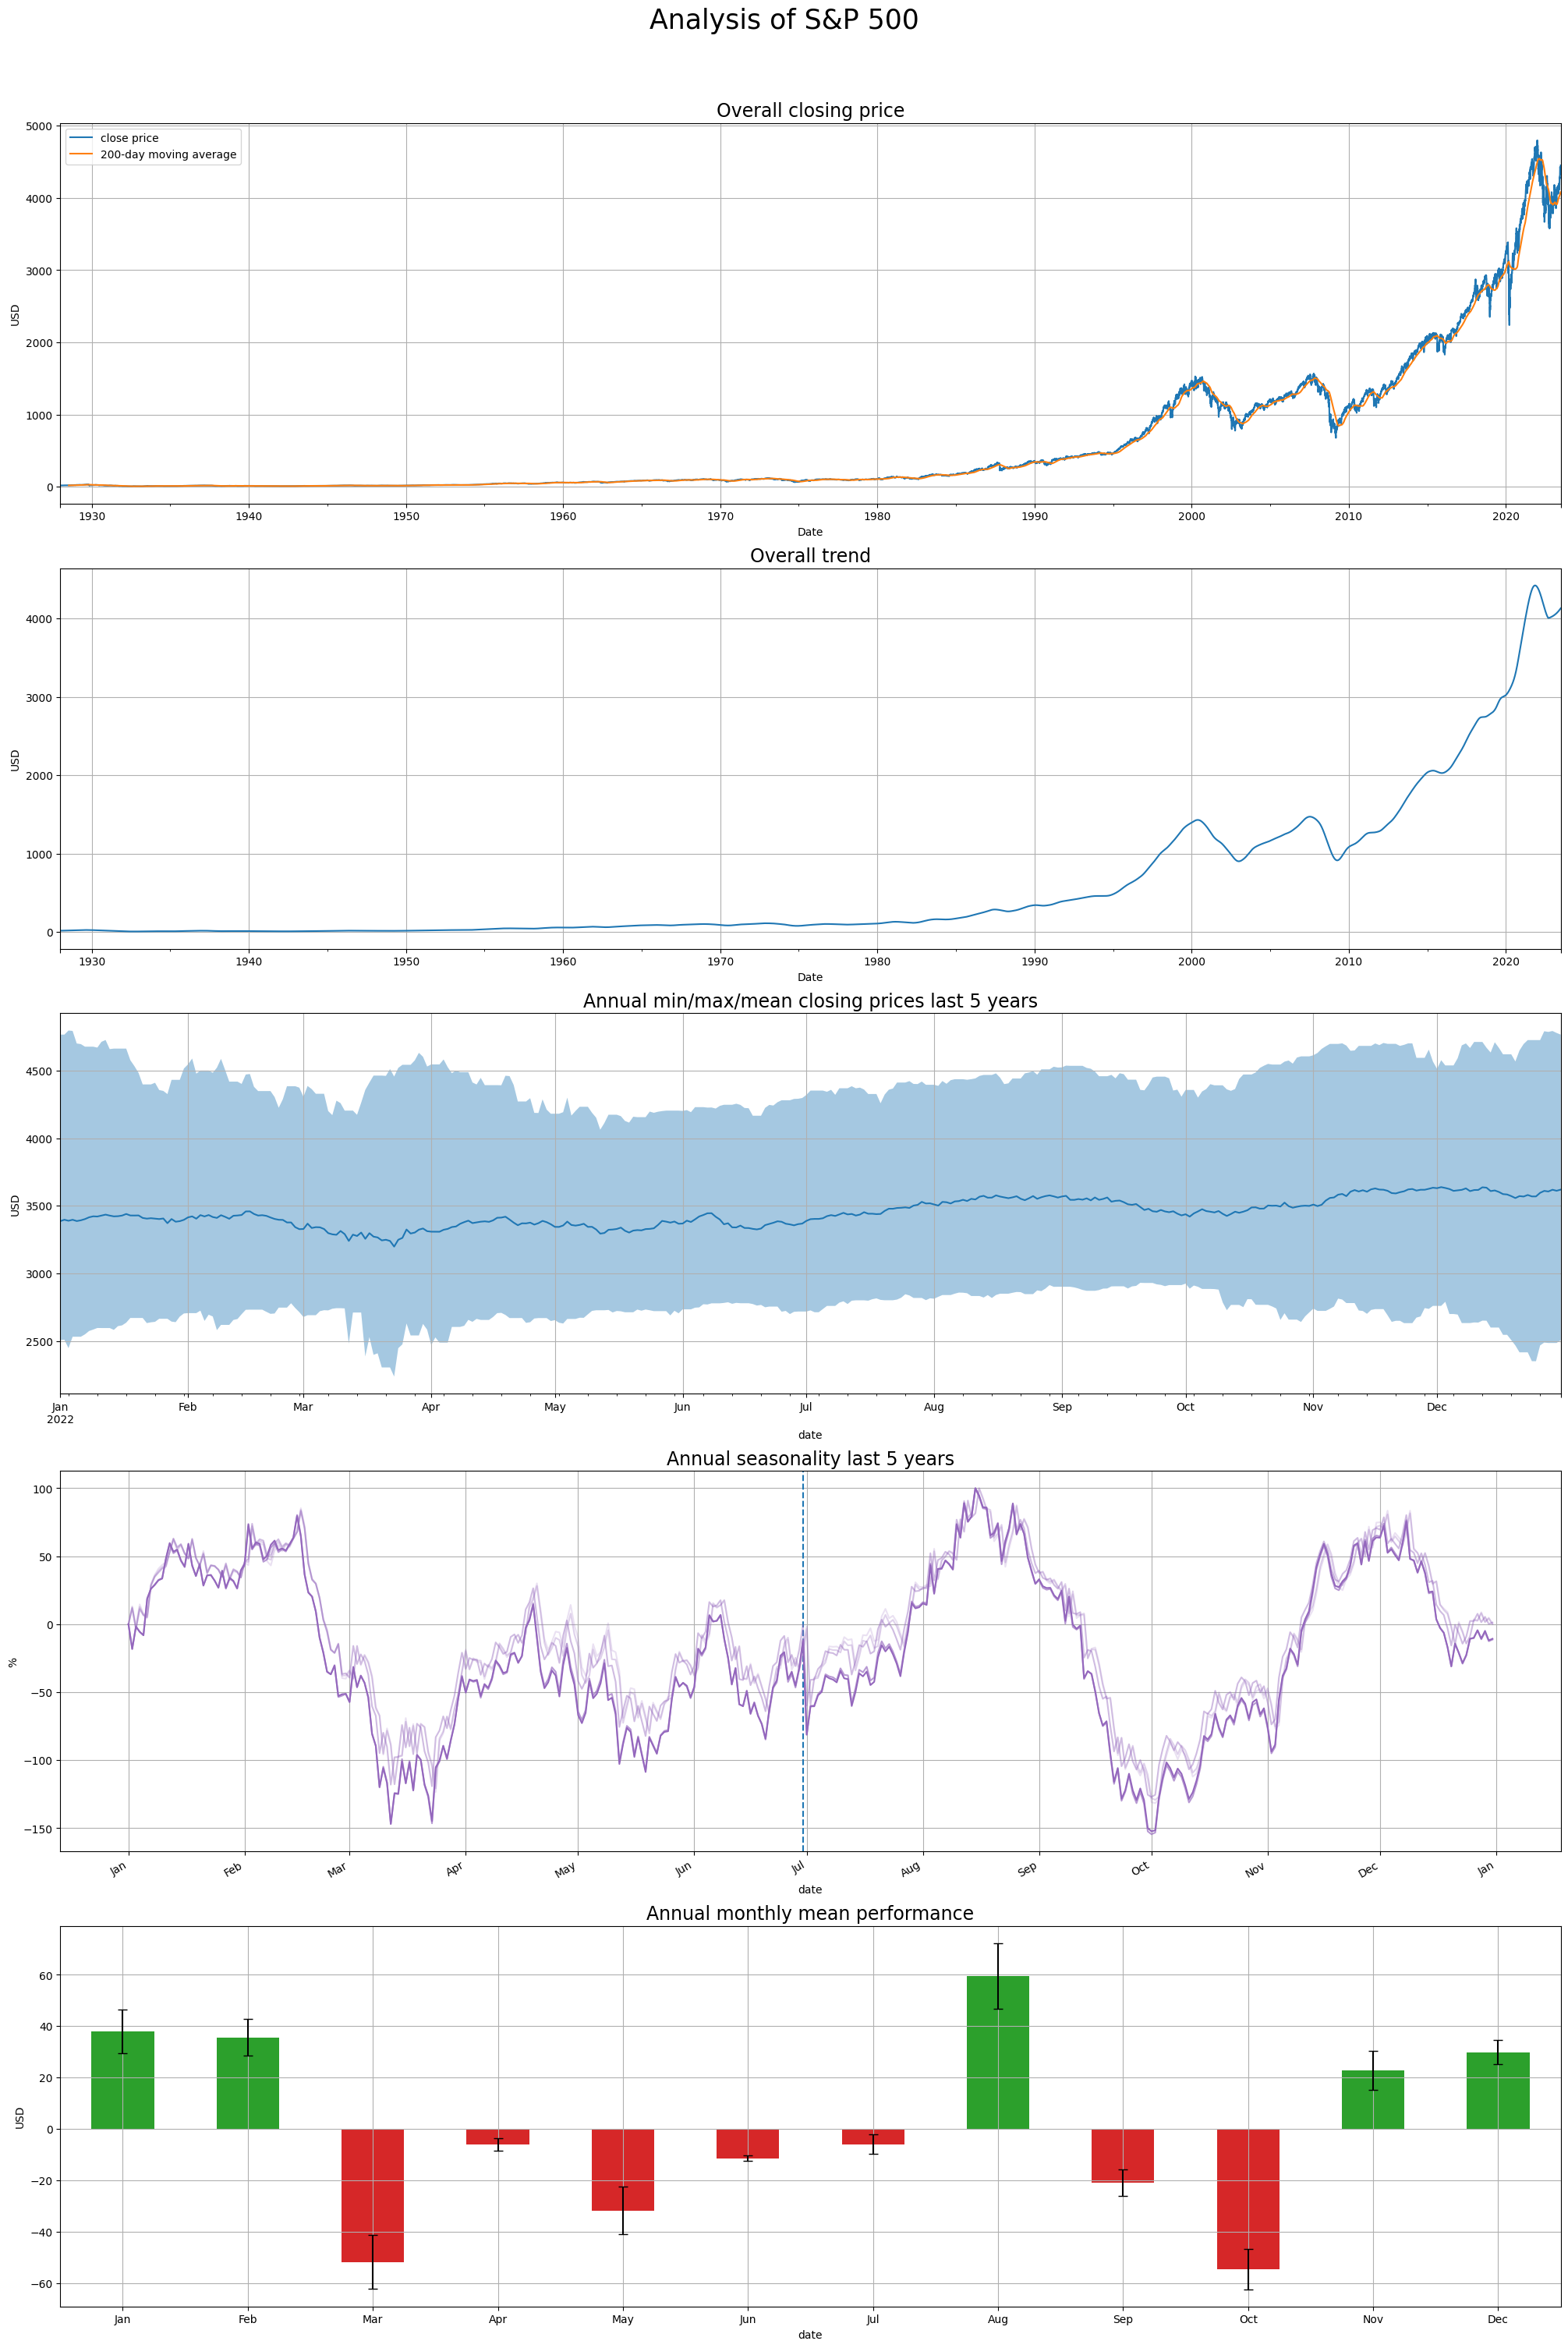

In [94]:
plt.figure(figsize=(20, 30), layout='constrained')
plt.suptitle(f'Analysis of {ticker.info["longName"]}\n\n', fontsize=25)

plt.subplot(511)
plt.title('Overall closing price', fontsize=17)
plt.ylabel(ticker.info['currency'])
df['Close'].plot(legend=True, label='close price')
df['Close'].rolling(rolling_resolution).mean().plot(legend=True, label=str(rolling_resolution) + '-day moving average', grid=True)

plt.subplot(512)
plt.title('Overall trend', fontsize=17)
plt.ylabel(ticker.info['currency'])
decompose.trend.plot(grid=True)

plt.subplot(513)
plt.title(f'Annual min/max/mean closing prices last {max_num_of_years} years', fontsize=17)
plt.fill_between(annualDf.index, annualDf['min'], annualDf['max'], alpha=0.4)
plt.ylabel(ticker.info['currency'])
annualDf['mean'].plot(grid=True)

plt.subplot(514)
plt.title(f'Annual seasonality last {max_num_of_years} years', fontsize=17)
plt.axvline(mdates.date2num(dt.datetime(lastYear, dt.date.today().month, dt.date.today().day)), linestyle='dashed')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b"))
if seasonalityInPercent:
    plt.ylabel('%')
else:
    plt.ylabel(ticker.info['currency'])
alpha_value = 1
for col in annualDf.columns:
    if col.startswith(periodNames[3]):
        if seasonalityInPercent:
            usedAnnualDf = 100 * (annualDf[col] - annualDf[col].iloc[0]) / (annualDf[col].max() - annualDf[col].iloc[0])
        else:
            usedAnnualDf = annualDf[col]
        usedAnnualDf.plot(color='tab:purple', alpha=alpha_value, grid=True)
        alpha_value = alpha_value * (1 - (2 / numOfYears))

plt.subplot(515)
plt.title('Annual monthly mean performance', fontsize=17)
plt.ylabel(ticker.info['currency'])
monthlyDf['mean'].plot(kind='bar', yerr=monthlyDf['std'], capsize=4, color=monthlyDf['meanPositive'].map({True: 'tab:green', False: 'tab:red'}), grid=True, rot=0)